In [120]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

A point is defined as a column vector. $ p = [x, y, z]^T $
The origin of the 3d coordinate system is the pinhole camera center. The camera is looking along the negative z-axis. The x-axis is pointing to the right and the y-axis is pointing downwards.

In [121]:
# define initial cube vertices

A = np.array([[-1, 1, 1]]).T
B = np.array([[1, 1, 1]]).T
C = np.array([[-1, 1, 3]]).T
D = np.array([[1, 1, 3]]).T
E = np.array([[-1, -1, 1]]).T
F = np.array([[1, -1, 1]]).T
G = np.array([[-1, -1, 3]]).T
H = np.array([[1, -1, 3]]).T
cube = np.hstack([A, B, C, D, E, F, G, H])
cube_hom = np.vstack([cube, np.array([1, 1, 1, 1, 1, 1, 1, 1])])

## projection
$\vec{p_c} = [u, v, 1]^T$ represents a pixel on the image plane, and $\vec{p_w} = [x_w, y_w, z_w, 1]^T $ represents a point in the world space (homogeneous coordinates). The pinhole camera model gives this equation to associate the two:

$$ z_c \begin{bmatrix} u \\ v \\ 1 \end{bmatrix}  = K \begin{bmatrix} R & T \end{bmatrix} 
\begin{bmatrix} x_w \\ y_w \\ z_w \\ 1 \end{bmatrix} = M \begin{bmatrix} x_w \\ y_w \\ z_w \\ 1 \end{bmatrix}$$

$K$ is the intrinsic matrix (internal parameters of the camera).
$RT$ form the extrinsic matrix, encoding the position and orientation of the camera in the world. By simply dividing by $z_c$, we get the equation:

$$ \begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = \frac{1}{z_c}M \begin{bmatrix} x_w \\ y_w \\ z_w \\ 1 \end{bmatrix}$$

or compactly:
$$ \vec{p_c} = \frac{1}{z_c}M \vec{p_w} $$

In this program I fix the camera to the origin, statically, making $R = I$ and $T = I$. With this,we just have:
$$ \vec{p_c} = \frac{1}{z_c}K \vec{p_w} $$

In [122]:
# define camera parameters
height = 1000
width = 1000
channels = 3



a_x = 30 #focal length
a_y = 30 #focal length
gamma = 0 #skkew coefficient between x and y axis
u_0 = width/2 #principal point
v_0 = height/2 #principal point
z_c = 1
K = np.array([[a_x, gamma, u_0, 0],
             [0, a_y, v_0, 0],
             [0, 0, 1, 0]])
print(K)
print(K.shape)

[[ 30.   0. 500.   0.]
 [  0.  30. 500.   0.]
 [  0.   0.   1.   0.]]
(3, 4)


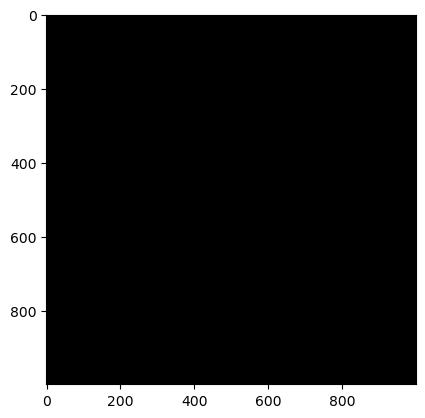

In [123]:
image = np.zeros((height, width, channels))
plt.imshow(image)

In [124]:
P_c = (1/z_c)*K@cube_hom
pixels = np.divide(P_c[:2, :], P_c[2:, :]).astype(int)
pixels

array([[470, 530, 490, 510, 470, 530, 490, 510],
       [530, 530, 510, 510, 470, 470, 490, 490]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


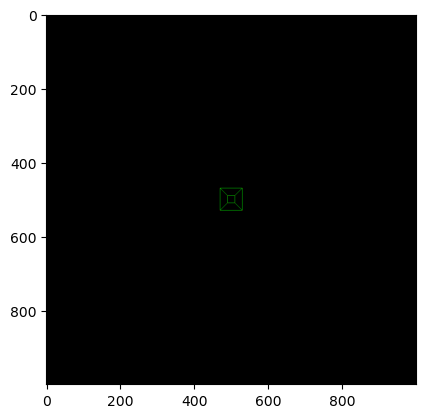

In [125]:
# mark the projections of the points/cube vertices
# connect the lines between the vertices
A_c = pixels[:,0]
B_c = pixels[:,1]
C_c = pixels[:,2]
D_c = pixels[:,3]
E_c = pixels[:,4]
F_c = pixels[:,5]
G_c = pixels[:,6]
H_c = pixels[:,7]

cv2.line(image, tuple(A_c), tuple(B_c), color=(0, 255, 0), thickness=1)
cv2.line(image, tuple(A_c), tuple(C_c), color=(0, 255, 0), thickness=1)
cv2.line(image, tuple(B_c), tuple(D_c), color=(0, 255, 0), thickness=1)
cv2.line(image, tuple(C_c), tuple(D_c), color=(0, 255, 0), thickness=1)
cv2.line(image, tuple(A_c), tuple(E_c), color=(0, 255, 0), thickness=1)
cv2.line(image, tuple(B_c), tuple(F_c), color=(0, 255, 0), thickness=1)
cv2.line(image, tuple(C_c), tuple(G_c), color=(0, 255, 0), thickness=1)
cv2.line(image, tuple(D_c), tuple(H_c), color=(0, 255, 0), thickness=1)
cv2.line(image, tuple(E_c), tuple(F_c), color=(0, 255, 0), thickness=1)
cv2.line(image, tuple(E_c), tuple(G_c), color=(0, 255, 0), thickness=1)
cv2.line(image, tuple(F_c), tuple(H_c), color=(0, 255, 0), thickness=1)
cv2.line(image, tuple(G_c), tuple(H_c), color=(0, 255, 0), thickness=1)

image[pixels[1, :], pixels[0, :]] = (255, 0, 0)
plt.imshow(image, cmap='gray')

Now we can rotate the cube with a 3d rotation matrix. The cube must be rotated about its centre. We can translate the cube to the origin, rotate, then translate back to its original position

In [126]:
cube_center = np.average(cube, axis=1).reshape((3, 1))
img_array = []

for theta in np.arange(0, 4*np.pi, 0.01):
    cube_trans = cube - cube_center
    R = np.array([[np.cos(theta), 0, np.sin(theta)],
                [0, 1, 0],
                [-np.sin(theta), 0, np.cos(theta)]])
    cube_rot_orig = R@cube_trans
    cube_rot = cube_rot_orig + cube_center
    cube_rot_hom = np.vstack([cube_rot, [1, 1, 1, 1, 1, 1, 1, 1]])

    image = np.zeros((height, width, channels))
    P_c = (1/z_c)*K@cube_rot_hom
    pixels = np.divide(P_c[:2, :], P_c[2:, :]).astype(int)
    A_c = pixels[:,0]
    B_c = pixels[:,1]
    C_c = pixels[:,2]
    D_c = pixels[:,3]
    E_c = pixels[:,4]
    F_c = pixels[:,5]
    G_c = pixels[:,6]
    H_c = pixels[:,7]

    cv2.line(image, tuple(A_c), tuple(B_c), color=(0, 255, 0), thickness=1)
    cv2.line(image, tuple(A_c), tuple(C_c), color=(0, 255, 0), thickness=1)
    cv2.line(image, tuple(B_c), tuple(D_c), color=(0, 255, 0), thickness=1)
    cv2.line(image, tuple(C_c), tuple(D_c), color=(0, 255, 0), thickness=1)
    cv2.line(image, tuple(A_c), tuple(E_c), color=(0, 255, 0), thickness=1)
    cv2.line(image, tuple(B_c), tuple(F_c), color=(0, 255, 0), thickness=1)
    cv2.line(image, tuple(C_c), tuple(G_c), color=(0, 255, 0), thickness=1)
    cv2.line(image, tuple(D_c), tuple(H_c), color=(0, 255, 0), thickness=1)
    cv2.line(image, tuple(E_c), tuple(F_c), color=(0, 255, 0), thickness=1)
    cv2.line(image, tuple(E_c), tuple(G_c), color=(0, 255, 0), thickness=1)
    cv2.line(image, tuple(F_c), tuple(H_c), color=(0, 255, 0), thickness=1)
    cv2.line(image, tuple(G_c), tuple(H_c), color=(0, 255, 0), thickness=1)

    image[pixels[1, :], pixels[0, :]] = [255, 255, 0]
    img_array.append(image.astype(np.uint8))

out = cv2.VideoWriter('project.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 100, (width, height), isColor=True)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()